In [18]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter

import sys
import logger

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [3]:
ALLDataset = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl/',filter_age=45)
ALLDataset.report()  # type: ignore
torch.cuda.empty_cache()# 清空显卡cuda
test_dataset = ECGDataset.ECG_Dataset(ALLDataset.testECGs,ALLDataset.testLabels,ALLDataset.testDf,preprocess= True,onehot_lable= False)  # type: ignore


              HTN        NHTN   
   nums       1871      103183  


            orginal            QC         
   nums      105054          65944        
              HTN        NHTN   
   nums       1344      64600   


            orginal   filtered department 
   nums      65944           13953        
              HTN        NHTN   
   nums       1344      12609   


            orginal     removed ages NaN  
   nums      13953           13953        
              HTN        NHTN   
   nums       1344      12609   


            orginal      filtered ages    
   nums      13953            5269        
              HTN        NHTN   
   nums       1344       3925   


            orginal   removed diagnose NaN
   nums       5269            5266        
              HTN        NHTN   
   nums       1344       3922   


              HTN        NHTN   
   ALL        1344       3922   
 testset      346        1606   
 T&V set      998        2316   
              HTN        NHTN 

In [4]:
NET = [Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
testmodel = NET[0].to(DEVICE)

In [5]:
Models_path = "./model/20221206_095840/"
testmodel.load_state_dict(torch.load(Models_path+"/parameter_EarlyStoping_"+str(0)+".pt"))
test_dataloader = Data.DataLoader(dataset=test_dataset, shuffle= False,batch_size=128)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 
print('f1_micro =',f1_score(y_true, y_pred, average='micro')) 
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print("Confusion Matrix: ")
print(cm)

loss = 0.4064604863524437 acc = 0.90380859375
f1_macro = 0.8380812956365976
f1_micro = 0.9052254098360656
Confusion Matrix: 
[[1512   94]
 [  91  255]]


GET CAM Value

In [6]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [7]:
testmodel.layers0.register_forward_hook(farward_hook)	#正向传播
testmodel.layers1.register_forward_hook(farward_hook) 
testmodel.layers2.register_forward_hook(farward_hook)	#正向传播
testmodel.layers3.register_forward_hook(farward_hook) 
testmodel.layers4.register_forward_hook(farward_hook)	#正向传播
testmodel.layers5.register_forward_hook(farward_hook) 
testmodel.layers6.register_forward_hook(farward_hook)	#正向传播
testmodel.layers7.register_forward_hook(farward_hook) 
testmodel.layers8.register_forward_hook(farward_hook)	#正向传播
testmodel.layers9.register_forward_hook(farward_hook) 
testmodel.layers10.register_forward_hook(farward_hook)	#正向传播
testmodel.layers11.register_forward_hook(farward_hook) 
testmodel.conv3.register_forward_hook(farward_hook) 
testmodel.layers_list_2d[0].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[1].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[2].register_forward_hook(farward_hook) 

In [8]:
branch_fmap_sum_HTN = np.zeros(27)
branch_fmap_sum_NHTN = np.zeros(27)
for itme in (range(845)):
    # testmodel.layer4.register_forward_hook(farward_hook)	#正向传播
    # testmodel.layer4.register_full_backward_hook(backward_hook)#反向传播
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_dataset.__getitem__(itme)
    labels = torch.tensor(labels)
    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  
    testmodel.eval()
    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    # loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # # loss = (testmodel.last_out)[0,pred]
    # loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    if(((labels.tolist())[0]) == torch.tensor(1)):
        for i in range(12):
            branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
            # print(fmap_block[i].size())
        for i in range(12,24):
            branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()
    else:
        for i in range(12):
            branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
            # print(fmap_block[i].size())
        for i in range(12,24):
            branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":


In [9]:
print(branch_fmap_sum_HTN,branch_fmap_sum_NHTN,branch_fmap_sum_HTN.size)

[ 5.59192913e+03 -1.24441352e-06 -1.21142427e-03 -5.00883514e-10
 -7.23948453e-02  4.62773706e-02 -1.27283407e-04 -4.06876055e-10
 -3.75885591e-15 -3.01829106e-07 -9.24349568e-11 -4.76705042e-11
  7.48341850e+04  7.37364870e+04  6.82782657e+04  6.86439291e+04
  6.91430865e+04  7.04142070e+04  7.06445977e+04  7.48691961e+04
  7.39648397e+04  7.37642955e+04  7.33456315e+04  7.23260848e+04
  5.37173438e+03  5.37173438e+03  5.37173438e+03] [ 1.70348788e+04 -5.41083600e-06 -5.26739542e-03 -2.17789224e-09
 -3.14780119e-01  2.01218694e-01 -5.53441144e-04 -1.76913829e-09
 -1.63438861e-14 -1.31238352e-06 -4.01916553e-10 -2.07276179e-10
  3.02695074e+05  3.11180303e+05  3.01223228e+05  2.88161785e+05
  2.71071272e+05  3.05237265e+05  3.08348080e+05  3.20460479e+05
  3.10881166e+05  3.11733950e+05  3.10324267e+05  3.08205947e+05
  5.47699072e+03  5.47699072e+03  5.47699072e+03] 27


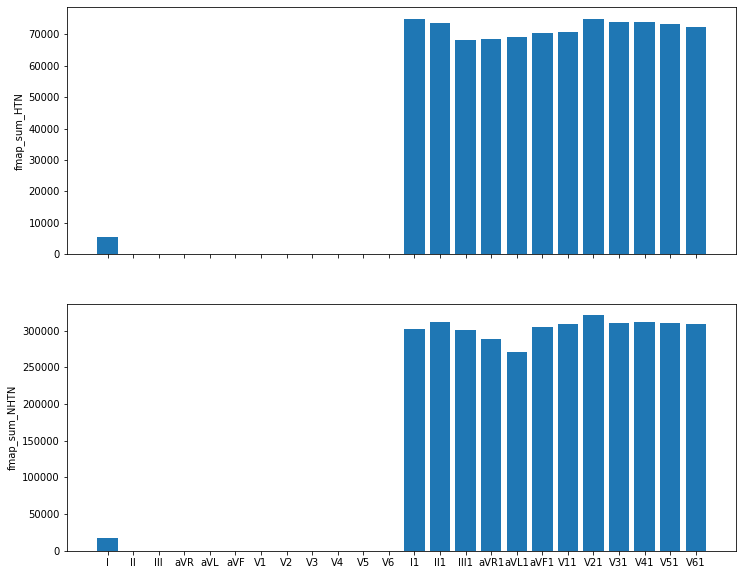

In [10]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6','I1', 'II1', 'III1', 'aVR1', 'aVL1', 'aVF1', 'V11', 'V21', 'V31', 'V41', 'V51', 'V61',]
counts = branch_fmap_sum_HTN[:24].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[:24].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

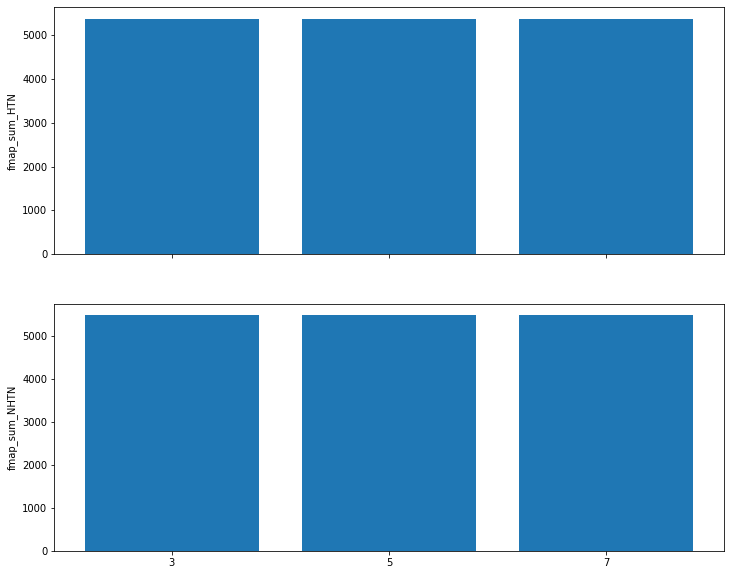

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['3', '5', '7']
counts = branch_fmap_sum_HTN[24:].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[24:].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

layer cam

In [13]:
NET = [Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
testmodel = NET[0].to(DEVICE)
testmodel.load_state_dict(torch.load(Models_path+"/parameter_EarlyStoping_"+str(0)+".pt"))

<All keys matched successfully>

In [14]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [15]:
testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播

In [16]:
def plot_top_attention_points(fig,axs,x,y,color_depend,cmap = "jet",y_name = "Voltage(mV)",title="",top_num = 100):
    axs.plot(x,y, color='black',linewidth=0.5)
    
    top_idx=color_depend.argsort()[::-1][0:top_num]
    axs.scatter(top_idx, y[top_idx],s=2,c='r')
    #fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(-3500, +3500)

    axs.set_aspect(0.2)#用于设置轴缩放的方面，即y-unit与x-unit的比率
    axs.xaxis.set_major_locator(plt.MultipleLocator(100))# type: ignore # 100*0.002s=0.2s = 5格
    axs.xaxis.set_minor_locator(plt.MultipleLocator(20)) # type: ignore # 20*0.002=0.004S = 1格
    axs.yaxis.set_major_locator(plt.MultipleLocator(500))# type: ignore # 0.1uv*500 = 0.5ms = 5格
    axs.yaxis.set_minor_locator(plt.MultipleLocator(100))# type: ignore # 0.1uv*100 =0.1ms = 1格 

    #axs.xaxis.set_major_formatter(plt.NullFormatter()) #x轴不显示刻度值/lable per 0.2s
    axs.xaxis.set_major_formatter(lambda x, pos: str(round(0.2*(x/100.0),2))) #x轴 lable per 0.2s
    axs.yaxis.set_major_formatter(lambda x, pos: str(x/1000.0)) # label per '0.5 mv'，turn uV to mv

    axs.grid(which='major', axis='x', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='x', linewidth=0.1, linestyle='-', color='b')
    axs.grid(which='major', axis='y', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='y', linewidth=0.1, linestyle='-', color='b')
    axs.set_ylabel(y_name)
    axs.set_title(title)
    axs.grid(True, which='both')

In [20]:
for itme in tqdm(range(10):
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_dataset.__getitem__(itme)

    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  

    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # loss = (testmodel.last_out)[0,pred]
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
    gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
    layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)
    lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    x_index = np.arange(0,EcgLength_num)
    fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
    ecg_data = (inputs[0]).to('cpu')
    for i,ax in enumerate(axs.flat):  # type: ignore
        attention_value_each_timestep = layer2d_vlue[i]
        #plot_y = x[1,i,:]*(4.88)
        plot_y = np.array(ecg_data[i]*3500.)
        ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
        plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)
    plt.savefig(Models_path+'/layer_cam//'+str(itme)+'_'+str(labels[0].tolist())+'_'+str(pred[0].tolist())+'_''.jpg', bbox_inches='tight',dpi = 100)

  1%|          | 11/1952 [03:10<9:20:27, 17.32s/it]


KeyboardInterrupt: 